In [1]:
## This is a test file to train to track an object
## Author : Avadesh Meduri
## Date : 8/04/2022

from matplotlib import pyplot as plt
import numpy as np

from torch.utils.data import Dataset
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision.io import read_image
from torch.utils.data import DataLoader, RandomSampler, Sampler
import time
import cv2
from PIL import Image
from skimage.io import imread
import numba
from torchvision.transforms import ToTensor, ToPILImage, Resize


In [2]:
# %timeit vr[np.random.randint(10)]
def tmp():
    box1 = read_image("./image_data/data1/color_" + str(np.random.randint(100)) + ".jpg")
    box2 = read_image("./image_data/data1/depth_" + str(np.random.randint(100)) + ".jpg")
    box = torch.vstack((box1, box2))
#     box = Image.open("./image_data/data2/" + str(np.random.randint(100)) + ".png")
#     box = (box)
#     print(box.shape)
#     box = imread("./image_data/data2/" + str(np.random.randint(100)) + ".png")
#     image = torch.tensor(box).float()
    
# %timeit tmp()
# %timeit image = imread("./image_data/data1/" + str(np.random.randint(10)) + ".jpg")

# %timeit image = cv2.imread("./image_data/data1/" + str(np.random.randint(10)) + ".jpg")


torch.Size([3, 240, 424])


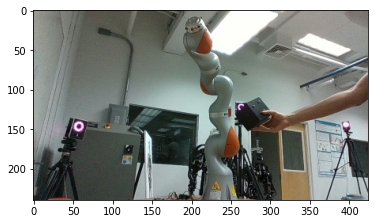

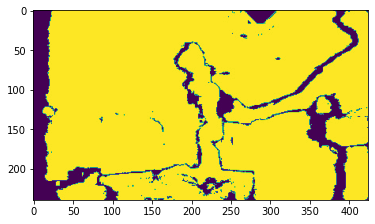

[0.24394054 0.29586894 0.43682699]


In [3]:
i = np.random.randint(1000)
box1 = ToTensor()(imread("./image_data/data10/color_" + str(i) + ".jpg"))
box2 = ToTensor()(imread("./image_data/data10/depth_" + str(i) + ".jpg"))
data = np.load("./position_data/" + "data10" + ".npz")
print(box1.shape)
plt.imshow(ToPILImage()(box1))
plt.show()
plt.imshow(ToPILImage()(box2))
plt.show()
print(data["position"][i])

In [4]:
class BoxDataSet(Dataset):
    
    def __init__(self, fname):
        
        self.img_dir = "./image_data/" + fname
        self.data = np.load("./position_data/" + fname + ".npz")
        self.y_train = torch.tensor(self.data["position"]).float()
        self.x_train = torch.zeros((len(self.y_train), 4, 240, 424))
        for i in range(len(self.y_train)):
            self.x_train[i] = self.read_image(i)
        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):

        return self.x_train[idx], self.y_train[idx]
    
    def read_image(self, idx):
        
        c_image = ToTensor()(imread(self.img_dir + "/color_" + str(idx) + ".jpg"))
        d_image = ToTensor()(imread(self.img_dir + "/depth_" + str(idx) + ".jpg"))
        image = torch.vstack((c_image, d_image)).float()
                            
        return image
    
    def get_data(self, idx):
    
        image = self.x_train[idx][None,:,:,:]
        label = self.y_train[idx]
        
        return image, label

In [5]:
class C_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 3, 3)
        self.conv3 = nn.Conv2d(3, 3, 3)
        self.fc1 = nn.Linear(4284, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def read_data(indices):
    dl_arr = []
    for i in range(len(indices)):
        print("loading", str(int(indices[i])), end = "\r", flush = True)
        dl_arr.append(DataLoader(BoxDataSet("data" + str(int(indices[i]))), batch_size = 128, num_workers = 12))
    return dl_arr

In [7]:
device = torch.device("cpu")
net = C_Net()
net.load_state_dict(torch.load("./models/cnn1"))
net = net.to(device)
lr = 1.5e-4
eps = 1000
num_data = 2
start = 1
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = torch.nn.MSELoss() #torch.nn.MSELoss() #torch.nn.HuberLoss()

In [ ]:
for i in range(eps):
    if i % 7 == 0:
        indices = torch.randperm(10)[:num_data] + 1
        dl_arr = read_data(indices)
    for x_train_batch, y_train_batch in dl_arr[np.random.randint(num_data)]:
        x_train_gpu = x_train_batch.to(device)
        y_train_gpu = y_train_batch.to(device)
        y_pred = net(x_train_gpu)
        error = loss(y_pred, y_train_gpu) 
        print("The iteration number : " + str(i) + " The loss is :" + str(error.cpu().detach().numpy()), end='\r', flush  = True)
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        
    if i % 10 == 0:
        torch.save(net.state_dict(), "./models/cnn1")
        
torch.save(net.state_dict(), "./models/cnn1")    

/home/ameduri/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
indices = torch.randperm(10)[:num_data] + 1
print(indices[1].numpy())

In [9]:
dl = BoxDataSet("data1")
net = C_Net()
net.load_state_dict(torch.load("./models/cnn1"))

<All keys matched successfully>

tensor([[0.2237, 0.3559, 0.6557]]) tensor([0.2505, 0.3417, 0.7785]) tensor(0.1265)


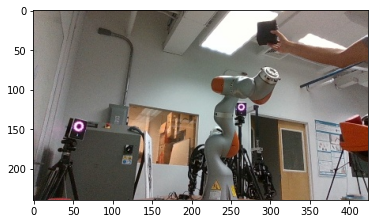

In [12]:
with torch.no_grad():
    img, label = dl.get_data(np.random.randint(50))
    pred = net(img.float())
    print(pred, label, torch.linalg.norm(pred - label))
    box = ToPILImage()(img[0][:3])
    plt.imshow(box)